# Demo: Dataset with NLP and image pixel representations

Note, that that this demo reproduces task inputs and targets that are converted to  image pixels and natural language inputs. We did not evaluate any models using this dataset format in the paper.



In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from gcog.models import rnn, transformer
import gcog.task.config as config
#### Pixel Word dataloader
import gcog.task.dataset_generator_pixelwords as datagen # DATASET objects
import gcog.task.task_generator as taskgen
from torch.utils.data import DataLoader
plt.rcParams['font.sans-serif'] = "Arial"
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Distractor generalization split (Fig. 3)


In [2]:
#### Distractor generalization split
dataset = 'comptree' # comptree ~ compositional tree structure
taskdepth = 1 # number of nodes to include; distractor generalization in the paper only uses single task operators
train_distractors = 5 # number of distractors to 'train' on
test_distractors = 40 # number of distractors to 'test' on; in the paper, we also include additional test splits for 10, 20, 30 distractors
ntrials = 5000 # number of randomly-sampled trials PER task operator
location_sampling = True # when randomly sampling object features, randomly sample from all possible locations (i.e., red 'a' at location (1,1))
nfeatures = 10 # number of object features to limit the model (i.e., only 10 colors and 10 shapes = 100 total color x shape combinations)

train_dataset = datagen.CompTreeDataset(tree_depth=taskdepth,
                                        n_distractors=train_distractors,
                                        distractor_range=True, # true: include trials with distractors ranging from 1 through train_distractors (randomly sampled)
                                        location=location_sampling,
                                        ntrials=ntrials,
                                        nfeatures=nfeatures)

test_dataset = datagen.CompTreeDataset(tree_depth=taskdepth,
                                        n_distractors=test_distractors,
                                        distractor_range=False, # false: only include trials with test_distractors
                                        location=location_sampling,
                                        ntrials=ntrials,
                                        nfeatures=nfeatures)
                                    

#### Print dataset statistics

In [3]:
print('Number of trials/samples:', len(train_dataset)) # Number of task operators (8) * ntrials

Number of trials/samples: 40000


#### Initialize dataloader (and simulate forward inference)

In [11]:
## Demonstration with just the trainloader; identical format with testloader

distractor_trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)

# Retrieve batch from dataloader 
# rule inputs are the task instruction input
# stim_inputs are the binarized stimulus input
# target_outputs are the output label (for classification task)
# task_ordering: for now, disregard task_ordering; it's not necessary
rule_inputs, stim_inputs, target_outputs, task_ordering = next(iter(distractor_trainloader)) 

# Rule and stim inputs have +1, to include the EOS token
print('Size of rule inputs:', len(rule_inputs)) # batch_size x string
print('Size of stim inputs:', stim_inputs.shape) # batch_size x width pixel x height pixel x rgb x 1 image
print('Size of target output:', target_outputs.shape) # batch_size, ranges from 1-138 (possible decision outputs/vocabulary)
## Outputs can be:
# Bool: True or False statement
# Location tuple: 100 possible locations on a 10x10 grid
# Shape identity: The identity of 26 possible shapes
# Color identity: The identity of 10 possible colors
# all together 138 possible output classifications


Size of rule inputs: 64
Size of stim inputs: torch.Size([64, 64, 64, 3, 1])
Size of target output: torch.Size([64])


#### Visualize example trials from train and test datasets

Instruction: loc of current white g ?
Target output: (4, 3)
Instruction: loc of current brown c ?
Target output: (4, 3)


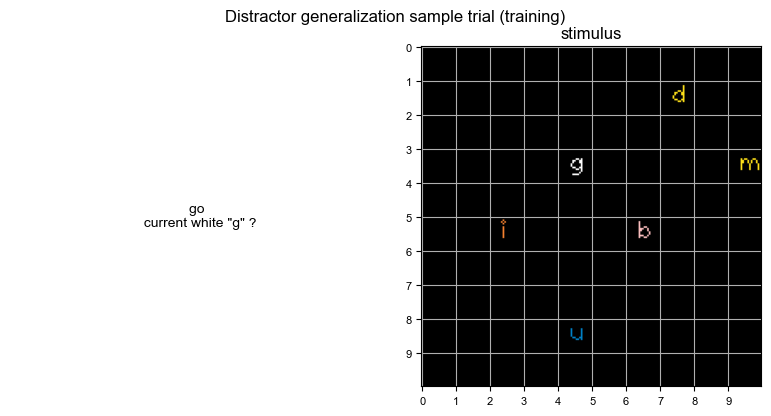

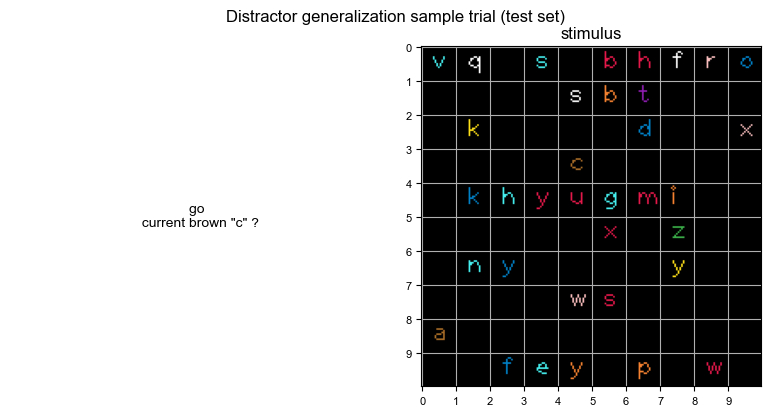

In [12]:
trial_idx = np.random.randint(0,len(train_dataset))
#### TRAINING SAMPLE
# Randomly select a trial number
# Extract the 'metatask' tree from dataset
metatask_train = train_dataset.metatasks[trial_idx]

# Generate stimuli
objset = metatask_train.generate_objset(n_distractor=train_distractors)
# Retrieve target label 
targets = metatask_train.get_target(objset)

print('Instruction:', metatask_train)
print('Target output:', targets[0])
img_array = objset.create_img()

plt.figure(figsize=(8,4))
plt.suptitle('Distractor generalization sample trial (training)')
plt.subplot(121)
metatask_train.task_graph.plot_graph()
plt.tight_layout()

plt.subplot(122)
plt.title('stimulus',fontsize=12,fontname='Arial')
plt.imshow(np.asarray(img_array[:,:,:,0],dtype='int16'))
plt.grid()
plt.xticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');
plt.yticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');


#### TESTSET SAMPLE
# Extract the 'metatask' tree from dataset
metatask_test = test_dataset.metatasks[trial_idx]

# Generate stimuli
objset = metatask_test.generate_objset(n_distractor=test_distractors)
# Retrieve target label 
targets = metatask_test.get_target(objset)

print('Instruction:', metatask_test)
print('Target output:', targets[0])
img_array = objset.create_img()

plt.figure(figsize=(8,4))
plt.suptitle('Distractor generalization sample trial (test set)')
plt.subplot(121)
metatask_test.task_graph.plot_graph()
plt.tight_layout()

plt.subplot(122)
plt.title('stimulus',fontsize=12,fontname='Arial')
plt.imshow(np.asarray(img_array[:,:,:,0],dtype='int16'))
plt.grid()
plt.xticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');
plt.yticks(np.arange(0,200,20),np.arange(0,10),fontsize=8,fontname='Arial');